In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import comet_ml
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
import seaborn as sb
# import linear_cca
# import multimodal_data
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles,readMergedProfiles2
# from utils.models import *
from utils.replicateCorrs import plotRepCorrs, replicateCorrs
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile,saveDF_to_CSV_GZ_no_timestamp
from importlib import reload
sns.set(color_codes=True)

# Load data



- CDRPBIO-BBBC047-Bray-CP-GE (Cell line: U2OS):
    * There are 30,430 and 21,782 unique compounds for CP and GE datasets, respectively.
    * Median number of replicates for each dataset is as follows: CP: ~4 , GE: ~3. 
    * 20,358 compounds are present in both datasets.
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (153386 , 1783) ,  ge:  (68120 , 977)
    * Treatment Level Shapes (nSamples x nFeatures): cp:  (30430, 1786)   ,  ge:  (21782, 981) 
    * Merged Profiles Shape:                              (20358, 2766)
    
    
- LUAD-BBBC041-Caicedo-CP-GE (Cell line: A549) : 
    * There are 593 and 529 unique alleles for CP and GE datasets, respectively.
    * Median number of replicates for each dataset is as follows: CP: ~8, GE: ~8.
    * 525 alleles are present in both datasets.
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (6144 , 1783) ,  ge:  (4232 , 978)
    * Treatment Level Shapes (nSamples x nFeatures): cp: (593, 1786) , ge: (529, 979) 
    * Merged Profiles Shape:                             (525, 2764)    
    
    
- TA-ORF-BBBC037-Rohban-CP-GE (Cell line: U2OS) :
    * There are 299 and 226 number of unique compounds for CP and GE datasets respectively.
    * Median number of replicates for each dataset is as follows: CP: ~5 , GE: ~2.
    * 188 alleles are present in both datasets.
    * Replicate Level Shapes (nSamples x nFeatures):         cp: (1920 , 1783) ,  ge: (729 , 978)
    * Treatment Level Shapes (nSamples x nFeatures+metadata):cp: (323, 1784)   ,  ge: (328, 979)
    * Merged Profiles Shape:                                     (149, 2762)
    
    
- LINCS-Pilot1-CP-GE (Cell line: A549) :
    * There are 1570 unique compounds across 7 doses for CP dataset
    * There are x unique compounds across 7 doses for GE dataset
    * Median number of replicates for each dataset is as follows: CP: ~5 , GE: ~3.
    * 6984 "compounds-dose" are present in both datasets. 
    * Replicate Level Shapes (nSamples x nFeatures):         cp: (52223 , 1747) ,  ge: (27837 , 978)
    * Treatment Level Shapes (nSamples x nFeatures+metadata):cp: (9394, 1748)   ,  ge: (8370, 979)
    * Merged Profiles Shape:                                     (6984, 2726)


In [9]:
ls ~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/L1000/

replicate_level_l1k.csv


In [15]:
dataset_rootDir='./';pertColName='PERT'

# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS'
dataset='LINCS';

# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized'
profileLevel='replicate'; #'replicate'  or  'treatment'

# n of samples for replicate picking options: numbers or, 'max'
nRep=8
mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
readMergedProfiles(dataset_rootDir,dataset,profileType,profileLevel,nRep);
# mergProf_repLevel,mergProf_treatLevel,l1k_features,cp_features,pertColName=readMergedProfiles(dataset,profileType,nRep)
# cp_features,l1k_features=cp_features.tolist(),l1k_features.tolist()


if profileLevel=='replicate':
    l1k=mergProf_repLevel[[pertColName]+l1k_features]
    cp=mergProf_repLevel[[pertColName]+cp_features]
elif profileLevel=='treatment':
    l1k=mergProf_treatLevel[[pertColName]+l1k_features]
    cp=mergProf_treatLevel[[pertColName]+cp_features]


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))

if 1:
    cp=cp_scaled.copy()
    l1k=l1k_scaled.copy()

In [34]:
# cp.columns
# mergProf_repLevel.columns
# mergProf_repLevel

### Separate training, Test and validation

In [5]:
con=[]
nTestAlleles=20;
# testAs=l1k[pertColName].sample(nTestAlleles,random_state=0).tolist()
testAs=l1k[pertColName].sample(nTestAlleles,random_state=0).tolist()
# testAs=['MAPK7_WT.c','ARAF_p.S214C','AKR1B1_p.P14R','PPP2R1A_p.V229L','PPP2R1A_p.Q372L',\
# 'IDH2_p.K130del','IDH2_p.S249G','RIT1_p.F82L','RIT1_p.A77P','RBM10_p.W658Y']

trainOverfit=1
con=[]
if trainOverfit:
    l1k_train=l1k.copy();l1k_test=l1k.copy()
    cp_train=cp.copy();cp_test=cp.copy()    
else:
    l1k_train=l1k[~l1k[pertColName].isin(testAs)].reset_index(drop=True)
    l1k_test=l1k[l1k[pertColName].isin(testAs)].reset_index(drop=True)

    cp_train=cp[~cp[pertColName].isin(testAs)].reset_index(drop=True)
#     cp_train[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
    cp_test=cp[cp[pertColName].isin(testAs)].reset_index(drop=True)

In [53]:
l1k_test.shape

(320, 979)

In [37]:
# corrAll
# pertColName
repC_all[1][1]

[]

In [16]:
len(corrAll)

2

In [38]:
# l1k_test.head()
# len(repC_all[1])
l1k_test

,PERT,201000_at,203192_at,209380_s_at,200045_at,202394_s_at,218581_at,221552_at,202123_s_at,214274_s_at,...,212124_at,202778_s_at,214741_at,204937_s_at,203521_s_at,218149_s_at,212557_at,219711_at,219968_at,204812_at
0,ABCB9_WT.o,2.077642,0.698606,-0.534857,0.887362,-0.471917,-0.735608,-0.407531,-0.636903,-0.162462,...,0.527383,-1.140849,-0.833550,0.299411,1.137247,0.778476,-0.233934,-0.382357,-0.434159,-0.881221
1,ABCB9_WT.o,1.534614,0.688283,-0.500406,1.016522,-1.437457,-0.869933,-0.222997,0.771341,-0.813212,...,1.040127,-0.783922,0.542507,-1.191931,-1.273562,1.446509,0.178128,0.003686,0.288276,0.003621
2,ABCB9_WT.o,0.579072,1.342209,-0.465908,0.334966,0.993418,-1.105046,-0.401883,0.736029,-0.480933,...,1.085667,-0.011353,0.594218,1.122792,-0.342289,-1.272235,0.784016,-0.053296,-0.082861,0.032286
3,ABCB9_WT.o,0.785945,0.689992,-0.368883,0.643180,0.415737,-0.390545,-0.196302,-0.164211,0.015006,...,1.128224,-0.999135,-0.010791,0.260416,-0.047112,-0.052999,0.380827,-0.215213,-0.457025,-0.593700
4,ABCB9_WT.o,1.376255,0.964173,-0.379040,1.581054,-1.397339,-0.167155,-0.247837,0.304204,-0.844658,...,0.555677,-0.865648,0.238362,-0.511635,0.111588,1.096665,1.183387,-0.136211,1.291880,-0.595627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13627,ZNF597_p.V21L,-1.508942,-0.697228,0.010695,0.980173,-0.703742,0.760567,0.290932,0.415455,1.144318,...,0.885470,-1.641462,-2.065951,-0.724676,-0.132006,0.862434,0.624428,-1.798262,0.675282,1.694897
13628,ZNF597_p.V21L,-0.371060,0.242562,-0.223875,-0.275610,-0.040674,1.301768,0.085650,0.155786,0.047547,...,-0.924645,0.149655,-0.677817,-0.439790,-1.832110,0.345633,-0.060117,-0.263082,0.105800,-0.711119
13629,ZNF597_p.V21L,-0.602956,0.455374,-0.254940,-1.228880,0.789829,1.079721,-0.179994,0.648689,0.168764,...,0.426213,0.148815,-0.835185,0.217526,-0.665233,-1.287341,-0.991288,5.187757,-0.742020,-0.858352
13630,ZNF597_p.V21L,-1.341381,0.193797,-0.369772,-0.755761,-1.501547,0.775363,-0.012064,1.034478,-0.046539,...,-1.157968,-0.657229,-1.573389,-1.021122,-0.508660,-0.115053,-1.220478,-0.037319,-0.270434,-0.013819


#### Replicate Correlation plots for CP and l1k in their ORIGINAL spaces

<IPython.core.display.Javascript object>


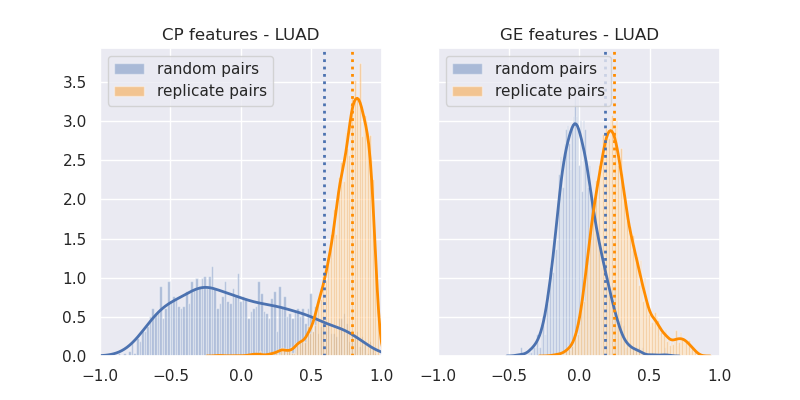

In [43]:
# corrAll=plotRepCorrs([[cp_test,cp_features],[l1k_test,l1k_features]],pertColName)
# np.random.seed(sum(map(ord, "distributions")))
repC_all=corrAll.copy()
title=['CP features - '+dataset,'GE features - '+dataset]
fig, axes = plt.subplots(1,len(repC_all),sharey='row', figsize=(8,4))
for i in range(len(repC_all)):
# sns.kdeplot(x)
    repCC=repC_all[i][1]
    randCC=repC_all[i][0]
    sns.distplot(randCC,kde=True,hist=True,bins=100,label="random pairs",ax=axes[i],norm_hist=True);
#     sns.kdeplot(randCC, bw=.4, label="random pairs",ax=axes[i])
#     sns.kdeplot(repCC, bw=.4, label="replicate pairs",ax=axes[i]);axes[i].set_xlabel('CC');
    sns.distplot(repCC,kde=True,hist=True,bins=100,label="replicate pairs",ax=axes[i],norm_hist=True,color='darkorange'); 
    perc5=np.percentile(repCC, 50);axes[i].axvline(x=perc5,linestyle=':',color='darkorange');
    perc95=np.percentile(randCC, 90);axes[i].axvline(x=perc95,linestyle=':');
    axes[i].set_xlim(-1,1);
    axes[i].legend();axes[i].set_title(title[i]);

In [ ]:
0

In [5]:
# repC_all[0]

In [105]:
# repC

# Linear CCA

In [21]:
# al1k_test.shape
from sklearn.cross_decomposition import CCA
# from DeepCCAmaster import DeepCCA,models,objectives
def cca_analysis2(l1k_train, cp_train, l1k_test, cp_test, outdim_size):
    
    GE_train = np.asarray(l1k_train)[:,1:]
    MF_train = np.asarray(cp_train)[:,1:]

    GE_test = np.asarray(l1k_test)[:,1:]
    MF_test = np.asarray(cp_test)[:,1:]    
    

    cca = CCA(n_components=outdim_size)
    cca.fit(GE_train, MF_train)
    X_c, Y_c = cca.transform(GE_test, MF_test)
#     wwmm=DeepCCA.linear_cca(new_data[0][0], new_data[0][1], outdim_size)
    return X_c, Y_c, []

In [17]:
# len(l1k[pertColName].unique())

# Deep CCA

In [7]:
def deep_cca_analysis(al1k_train_0, acp_train_0, al1k_test, acp_test, outdim_size,valEnabled,n_epoch):
    experiment = comet_ml.Experiment(
        api_key='wRu2GizrrhvMrx22c5346ocuq',
        project_name='Rosetta-cca'
    )
    import sys
    sys.path.insert(0, '../')
    sys.path.insert(0, '../DeepCCAmaster')
    from DeepCCAmaster import DeepCCA,models,objectives
    le = preprocessing.LabelEncoder()
    
    pertColName=al1k_train_0.columns[0]
    l1kAl=al1k_train_0[pertColName].tolist()+al1k_test[pertColName].tolist()
    le.fit(list(set(l1kAl)))

    nValAlleles=4;
    valAs=al1k_train_0[pertColName].sample(nValAlleles).tolist()
#     print(valAs)
    if valEnabled:
#         valAs=['PPP2R1A_p.C329F', 'TP53_p.V272K', 'EBNA1BP2_WT.o', 'KEAP1_WT.o']
        al1k_train=al1k_train_0[~al1k_train_0[pertColName].isin(valAs)].reset_index(drop=True)
        al1k_val=al1k_train_0[al1k_train_0[pertColName].isin(valAs)].reset_index(drop=True)

        acp_train=acp_train_0[~acp_train_0[pertColName].isin(valAs)].reset_index(drop=True)
        acp_val=acp_train_0[acp_train_0[pertColName].isin(valAs)].reset_index(drop=True)
    else:
        al1k_train=al1k_train_0.copy()
        al1k_val=al1k_train_0.copy()
        acp_train=acp_train_0.copy()
        acp_val=acp_train_0.copy()        
        
    lx_tr=al1k_train.iloc[:,1:].values;
    ly_tr=le.transform(al1k_train[pertColName].tolist())
    lx_v=al1k_val.iloc[:,1:].values;
    ly_v=le.transform(al1k_val[pertColName].tolist())
    lx_te=al1k_test.iloc[:,1:].values;
    ly_te=le.transform(al1k_test[pertColName].tolist())

    cx_tr=acp_train.iloc[:,1:].values;
    cy_tr=le.transform(acp_train[pertColName].tolist())
    cx_v=acp_val.iloc[:,1:].values;
    cy_v=le.transform(acp_val[pertColName].tolist())    
    cx_te=acp_test.iloc[:,1:].values;
    cy_te=le.transform(acp_test[pertColName].tolist())

    
    # Prepare Gene Expression matrix
#     sc_l1k = sklearn.preprocessing.StandardScaler()
#     sc_l1k.fit(lx_tr)
#     lx_tr = sc_l1k.transform(lx_tr)
#     lx_te = sc_l1k.transform(lx_te)
    
#     pca_l1k = sklearn.decomposition.PCA(n_components=150, svd_solver="full")
#     pca_l1k.fit(GE)
#     GE = pca_l1k.transform(GE)

    # Prepare Cell Painting matrix
#     sc_cp = sklearn.preprocessing.StandardScaler()
#     sc_cp.fit(cx_tr)
#     cx_tr = sc_cp.transform(cx_tr)
#     cx_te = sc_cp.transform(cx_te)
    
    
    data2=((lx_tr,ly_tr),(lx_v,ly_v),(lx_te,ly_te))
    data1=((cx_tr,cy_tr),(cx_v,cy_v),(cx_te,cy_te))    
    
    
#     pca_cp = sklearn.decomposition.PCA(n_components=100, svd_solver="full")
#     pca_cp.fit(MF)
#     MF = pca_cp.transform(MF)

    # the size of the new space learned by the model (number of the new features)
#     outdim_size = 20

    # size of the input for view 1 and view 2
    # input_shape1 = 784
    # input_shape2 = 784
    input_shape1 = acp_train.shape[1]-1
    input_shape2 = al1k_train.shape[1]-1

    # number of layers with nodes in each one
    nFilts=64
#     nFilts=2*1024;
    layer_sizes1 = [nFilts, nFilts, nFilts, outdim_size]
    layer_sizes2 = [nFilts, nFilts, nFilts, outdim_size]

    # the parameters for training the network
    learning_rate = 1e-3
#     epoch_num = 2000
    epoch_num=n_epoch
#     epoch_num = 250
    # batch_size = 800
    batch_size =len(set(l1kAl))*2
    
    # the regularization parameter of the network
    # seems necessary to avoid the gradient exploding especially when non-saturating activations are used
    reg_par = 1e-4

    # specifies if all the singular values should get used to calculate the correlation or just the top outdim_size ones
    # if one option does not work for a network or dataset, try the other one
    use_all_singular_values = False

    # if a linear CCA should get applied on the learned features extracted from the networks
    # it does not affect the performance on noisy MNIST significantly
    apply_linear_cca = True
    
    # Compute CCA       
#     A, B, D, ma, mb = linear_cca.linear_cca(MF, GE, 10)

    # Building, training, and producing the new features by DCCA


    model = models.create_model(layer_sizes1, layer_sizes2, input_shape1, input_shape2,
                            learning_rate, reg_par, outdim_size, use_all_singular_values)
    model.summary()
    model = DeepCCA.train_model(model, data1, data2, epoch_num, batch_size)
    new_data = DeepCCA.test_model(model, data1, data2, outdim_size, apply_linear_cca)

#     X=new_data
    cx_cca_te, lx_cca_te, label_te = new_data[2]
#     X = sc_cp.transform(MF_test)
#     Y = sc_l1k.transform(GE_test)
    
#     X = np.dot(X, A)
#     Y = np.dot(Y, B)
    
    return cx_cca_te, lx_cca_te, label_te

In [131]:
o

60

In [9]:
l1k_train

,PERT,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,...,204662_at,203047_at,203343_at,217995_at,218450_at,212536_at,218529_at,211071_s_at,203341_at,205379_at
0,BRD-A03506276_0.04,-0.025548,-0.239241,-0.786256,-0.647896,-0.096685,-0.092526,-0.844540,-1.109428,-0.311051,...,0.204794,-0.296341,0.310805,0.827393,-0.521966,-0.490434,0.457207,0.975030,-0.234945,0.579001
1,BRD-A03506276_0.04,0.746604,0.516255,-0.758399,-1.188520,-1.368686,-1.032235,-0.484035,-0.371749,0.879224,...,-0.932719,-0.113938,0.554774,0.655489,-0.579212,-0.831939,-0.087130,0.749133,-0.608854,0.859330
2,BRD-A03506276_0.04,-0.582954,-1.421422,-0.170553,-1.249446,-2.692093,-0.796649,0.024874,0.647152,0.396517,...,0.677608,-0.020737,0.413205,1.160321,-0.063183,-0.868492,0.679320,0.736982,1.253399,-0.821231
3,BRD-A03506276_0.04,-0.025548,-0.239241,-0.786256,-0.647896,-0.096685,-0.092526,-0.844540,-1.109428,-0.311051,...,0.204794,-0.296341,0.310805,0.827393,-0.521966,-0.490434,0.457207,0.975030,-0.234945,0.579001
4,BRD-A03506276_0.04,0.746604,0.516255,-0.758399,-1.188520,-1.368686,-1.032235,-0.484035,-0.371749,0.879224,...,-0.932719,-0.113938,0.554774,0.655489,-0.579212,-0.831939,-0.087130,0.749133,-0.608854,0.859330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16546,DMSO,-0.914442,-1.253137,-0.469148,-0.641106,1.024807,-0.104042,-0.655162,-0.584220,0.146814,...,-0.348352,-0.069420,0.354284,-1.021597,1.006159,-0.237778,-0.038531,-0.191508,-1.166564,-1.366855
16547,DMSO,-1.085752,1.173285,-6.054265,-0.674228,0.544733,-0.159843,-0.870372,0.004467,-0.156134,...,-0.638419,-0.259395,0.239729,-0.777576,-0.741071,-0.765911,0.462147,0.181333,0.113106,0.277901
16548,DMSO,-0.310930,1.038051,1.566263,0.097411,0.256692,-0.738396,-0.602152,1.539327,-1.115613,...,0.820510,-0.009222,1.007818,-1.172830,2.147493,0.433755,-0.181314,-1.229415,0.086184,0.842271
16549,DMSO,-0.060248,0.913974,0.382387,-0.648504,-0.963014,1.592194,-0.732499,0.158593,-2.079601,...,0.022831,0.620960,-0.023377,-0.631633,-1.038663,0.707914,-0.326617,0.253828,0.470259,0.452275


In [52]:
np.asarray(testAs)

array(['KRAS_p.G13D', 'RIT1_p.A77P', 'STK11_WT.c', 'STC2_WT.o',
       'NFE2L2_WT.o', 'EGFR_p.ELREA746del', 'PIK3CA_p.123_124MP>IA',
       'RBM10_p.G153C', 'STC2_p.R5W', 'SOX2_WT.o', 'STK11_WT.o',
       'TPK1_p.T213S', 'PIK3CA_p.H1047R', 'BRAF_p.H574Q', 'STK11_p.H168R',
       'NR4A2_p.R572G', 'MAP2K1_WT.c', 'RIT1_WT.c', 'TP53_p.E224D',
       'PPP2R1A_p.W140C'], dtype='<U21')

### Check if samples in latent space are connected - Linear CCA
 * 1 - When we use all data for training
 * 2 - When we use 20 perts for test 

In [19]:
con=[]
nTestAlleles=20;
# testAs=l1k[pertColName].sample(nTestAlleles).tolist()
testAs=['KRAS_p.G13D', 'RIT1_p.A77P', 'STK11_WT.c', 'STC2_WT.o',
       'NFE2L2_WT.o', 'EGFR_p.ELREA746del', 'PIK3CA_p.123_124MP>IA',
       'RBM10_p.G153C', 'STC2_p.R5W', 'SOX2_WT.o', 'STK11_WT.o',
       'TPK1_p.T213S', 'PIK3CA_p.H1047R', 'BRAF_p.H574Q', 'STK11_p.H168R',
       'NR4A2_p.R572G', 'MAP2K1_WT.c', 'RIT1_WT.c', 'TP53_p.E224D',
       'PPP2R1A_p.W140C']

# 0.52,56,39,.3,
# na,.8,
trainOverfit=1
con=[]
if trainOverfit:
#     l1k=l1k.fillna(l1k.median())
#     cp=cp.fillna(l1k.median())
    cp = cp.interpolate()
    l1k = l1k.interpolate()
    
    l1k_train=l1k.copy();l1k_test=l1k.copy()
    cp_train=cp.copy();cp_test=cp.copy()    
else:
    l1k_train=l1k[~l1k[pertColName].isin(testAs)].reset_index(drop=True)
    l1k_test=l1k[l1k[pertColName].isin(testAs)].reset_index(drop=True)

    cp_train=cp[~cp[pertColName].isin(testAs)].reset_index(drop=True)
    cp_test=cp[cp[pertColName].isin(testAs)].reset_index(drop=True)


# for o in range(20,100,10):
for o in [40]:
    outdim_size=o;
    MF_v_l, GE_v_l, D_n= cca_analysis2(l1k_train[l1k_features], cp_train[cp_features], l1k_test[l1k_features],\
                                       cp_test[cp_features], outdim_size);

    MF_v=np.copy(MF_v_l); GE_v=np.copy(GE_v_l);

#     D = scipy.spatial.distance_matrix(MF_v, GE_v,p=2)
    D = scipy.spatial.distance.cdist(MF_v, GE_v, 'correlation')
    connected2 = 0;
    
    for i in range(MF_v.shape[0]):
    #     print(D[i,i],np.min(D[i,:]))
#         if D[i,i]==np.min(D[i,:]):
        ind=l1k_test[l1k_test[pertColName]==l1k_test.loc[i,pertColName]].index.tolist()
        distanceOfAiCpToGEofSamePert=D[i,ind];
        if np.min(D[i,:]) in distanceOfAiCpToGEofSamePert:
            connected2 += 1
    
    con.append(connected2)
    
print(con,' out of ', cp_test.shape[0])

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


[7601]  out of  16551


In [18]:
cols2removeCP=[i for i in cp.columns.tolist() if cp[i].isnull().sum(axis=0)>0]
print(cols2removeCP)
# cp=cp.drop(cols2removeCP, axis=1);
cp = cp.interpolate()

cols2removeGE=[i for i in l1k.columns.tolist() if l1k[i].isnull().sum(axis=0)>0]
print(cols2removeGE)

[]
[]


In [6]:
# l1k

In [ ]:
# Replicate level:
# TAORF for o in range(10,70,10)
[1288, 2028, 2148, 2184, 2192, 2184]  out of  2192

# CDRP for o in range(10,70,10)
[568, 968, 1444, 1864, 2464, 2980]  out of  13928


# Treatment level:
# TAORF for o in range(10,70,10)


# CDRP for o in range(20,100,10):
[1913, 1921, 1921, 1921, 1921, 1921, 1921, 1921]  out of  1921

In [74]:
connected2 = 0;

for i in range(MF_v.shape[0]):
#     print(D[i,i],np.min(D[i,:]))
#         if D[i,i]==np.min(D[i,:]):
    ind=l1k_test[l1k_test[pertColName]==l1k_test.loc[i,pertColName]].index.tolist()
    distanceOfAiCpToGEofSamePert=D[i,ind];
    if np.min(D[i,:]) in distanceOfAiCpToGEofSamePert:
        connected2 += 1

con.append(connected2)

In [75]:
connected2

18752

In [72]:
# np.concatenate((cp_test.iloc[:,0].T,MF_v_l),axis=0)
ind=l1k_test[l1k_test[pertColName]==l1k_test.loc[i,pertColName]].index
distanceOfAiCpToGEofSamePert=D[i,ind];
if np.min(D[i,:]) in distanceOfAiCpToGEofSamePert:
#     print('hello')

In [9]:
# cp_new=pd.DataFrame(MF_v_l)
# cp_new.insert(0,cp_test.columns[0],cp_test.iloc[:,0])

In [11]:
# cp_new

In [12]:
# cp_new

In [157]:
# # con=[]
# D = scipy.spatial.distance.cdist(MF_v, GE_v, 'correlation')
# connected2 = 0;
# for i in range(MF_v.shape[0]):
# #     print(D[i,i],np.min(D[i,:]))
#     if D[i,i]==np.min(D[i,:]):
#         connected2 += 1

# # con.append(connected2)
# print(connected2)

In [ ]:
MF_v_l, GE_v_l

<IPython.core.display.Javascript object>


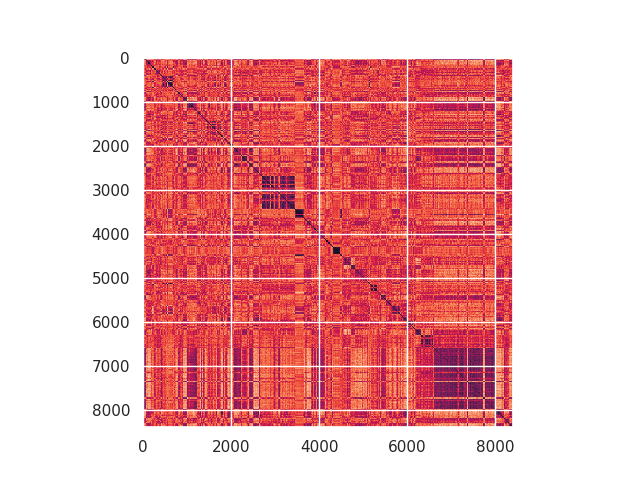

In [9]:
# GE_v_nn.shape
# D = sklearn.metrics.pairwise_distances(MF_v, GE_v, metric='correlation')
# D = scipy.spatial.distance.squareform(MF_v, GE_v)
D = scipy.spatial.distance.cdist(MF_v, GE_v, 'correlation')
plt.figure()
plt.imshow(D.T);

In [145]:
D[1,30],D[30,1],D.shape

(0.9177309354406413, 0.7238779817035088, (320, 320))

In [99]:
# cp_new.head()
GE_v_nn.shape

(1921, 40)

### Check if samples in latent space are connected - Deep CCA
 * 1 - When we use all data for training
 * 2 - When we use 20 perts for test 

In [34]:
# outdim_size=40;
# MF_v_lin, GE_v_lin, D_l = cca_analysis(l1k, cp, l1k, cp,outdim_size);
trainOverfit=1
con=[]
if trainOverfit:
    l1k_train=l1k.copy();l1k_test=l1k.copy()
    cp_train=cp.copy();cp_test=cp.copy()    
    valEnabled=0;
else:
    l1k_train=l1k[~l1k[pertColName].isin(testAs)].reset_index(drop=True)
    l1k_test=l1k[l1k[pertColName].isin(testAs)].reset_index(drop=True)

    cp_train=cp[~cp[pertColName].isin(testAs)].reset_index(drop=True)
    cp_test=cp[cp[pertColName].isin(testAs)].reset_index(drop=True)
    valEnabled=1;
    
    
# for o in range(20,100,10):    
# for o in [40]:
for o in [40]:
    outdim_size=o;
    n_epoch=1800;
#     n_epoch=200 used for moa classifixation CDRP
    MF_v_nn, GE_v_nn, D_n= deep_cca_analysis(l1k_train, cp_train, l1k_test, cp_test, outdim_size,valEnabled,n_epoch);

    MF_v=np.copy(MF_v_nn); GE_v=np.copy(GE_v_nn);

    D_nn = scipy.spatial.distance_matrix(MF_v, GE_v)
    connected2 = 0;

    for i in range(MF_v.shape[0]):
    #     print(D[i,i],np.min(D[i,:]))
    #         if D[i,i]==np.min(D[i,:]):
        ind=l1k_test[l1k_test[pertColName]==l1k_test.loc[i,pertColName]].index.tolist()
        distanceOfAiCpToGEofSamePert=D_nn[i,ind];
        if np.min(D_nn[i,:]) in distanceOfAiCpToGEofSamePert:
            connected2 += 1

    con.append(connected2)
print(con,' out of ', cp_test.shape[0])

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/marziehhaghighi/rosetta-cca/e83faead8a3442b0ae4f1ec743cdf6ff
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [1800]              : (-36.99870300292969, -4.778031349182129)
COMET INFO:     epoch_duration [1800]          : (0.016271788626909256, 0.5673351176083088)
COMET INFO:     loss [1800]                    : (-36.99870300292969, -4.778031349182129)
COMET INFO:     step                           : 1800
COMET INFO:     sys.gpu.0.free_memory [208]    : (12437880832.0, 12438929408.0)
COMET INFO:     sys.gpu.0.gpu_utilization [208]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory         : (12796690432.0, 12796690432.0)
COMET INFO:     sys.gpu.0.used_memory [208]    : (357761024.0, 358809600.0)
COMET INFO:     sys.gpu.1.free_memory [208]    : (12775915520.0, 12775915520.0)
COMET INFO:     sys.gpu.1.gpu_utilization [208]: (0

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_9_input (InputLayer)      (None, 1677)         0                                            
__________________________________________________________________________________________________
dense_13_input (InputLayer)     (None, 978)          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 64)           107392      dense_9_input[0][0]              
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           62656       dense_13_input[0][0]             
__________________________________________________________________________________________________
dense_10 (

Epoch 28/1800
1460/1460 [==============================] - 0s 132us/step - loss: -24.4023 - val_loss: -18.6538

Epoch 00028: val_loss improved from -18.46236 to -18.65385, saving model to temp_weights.h5
Epoch 29/1800
1460/1460 [==============================] - 0s 123us/step - loss: -24.7281 - val_loss: -18.8338

Epoch 00029: val_loss improved from -18.65385 to -18.83383, saving model to temp_weights.h5
Epoch 30/1800
1460/1460 [==============================] - 0s 118us/step - loss: -25.0254 - val_loss: -19.0283

Epoch 00030: val_loss improved from -18.83383 to -19.02827, saving model to temp_weights.h5
Epoch 31/1800
1460/1460 [==============================] - 0s 113us/step - loss: -25.4034 - val_loss: -19.2090

Epoch 00031: val_loss improved from -19.02827 to -19.20898, saving model to temp_weights.h5
Epoch 32/1800
1460/1460 [==============================] - 0s 116us/step - loss: -25.6985 - val_loss: -19.3869

Epoch 00032: val_loss improved from -19.20898 to -19.38687, saving model

1460/1460 [==============================] - 0s 136us/step - loss: -33.9678 - val_loss: -23.9286

Epoch 00109: val_loss improved from -23.91010 to -23.92861, saving model to temp_weights.h5
Epoch 110/1800
1460/1460 [==============================] - 0s 144us/step - loss: -33.9297 - val_loss: -23.9228

Epoch 00110: val_loss did not improve from -23.92861
Epoch 111/1800
1460/1460 [==============================] - 0s 136us/step - loss: -34.0341 - val_loss: -23.9552

Epoch 00111: val_loss improved from -23.92861 to -23.95519, saving model to temp_weights.h5
Epoch 112/1800
1460/1460 [==============================] - 0s 137us/step - loss: -33.9737 - val_loss: -23.9636

Epoch 00112: val_loss improved from -23.95519 to -23.96355, saving model to temp_weights.h5
Epoch 113/1800
1460/1460 [==============================] - 0s 138us/step - loss: -34.0028 - val_loss: -23.9792

Epoch 00113: val_loss improved from -23.96355 to -23.97917, saving model to temp_weights.h5
Epoch 114/1800
1460/1460 [===

1460/1460 [==============================] - 0s 123us/step - loss: -35.0469 - val_loss: -24.6229

Epoch 00196: val_loss did not improve from -24.65985
Epoch 197/1800
1460/1460 [==============================] - 0s 120us/step - loss: -35.0324 - val_loss: -24.6306

Epoch 00197: val_loss did not improve from -24.65985
Epoch 198/1800
1460/1460 [==============================] - 0s 119us/step - loss: -35.0552 - val_loss: -24.6614

Epoch 00198: val_loss improved from -24.65985 to -24.66136, saving model to temp_weights.h5
Epoch 199/1800
1460/1460 [==============================] - 0s 123us/step - loss: -35.0495 - val_loss: -24.6334

Epoch 00199: val_loss did not improve from -24.66136
Epoch 200/1800
1460/1460 [==============================] - 0s 119us/step - loss: -35.0666 - val_loss: -24.6486

Epoch 00200: val_loss did not improve from -24.66136
Epoch 201/1800
1460/1460 [==============================] - 0s 123us/step - loss: -35.0876 - val_loss: -24.6718

Epoch 00201: val_loss improved fr

1460/1460 [==============================] - 0s 121us/step - loss: -34.9304 - val_loss: -24.5312

Epoch 00293: val_loss did not improve from -24.71173
Epoch 294/1800
1460/1460 [==============================] - 0s 136us/step - loss: -34.9377 - val_loss: -24.4873

Epoch 00294: val_loss did not improve from -24.71173
Epoch 295/1800
1460/1460 [==============================] - 0s 138us/step - loss: -34.9341 - val_loss: -24.4815

Epoch 00295: val_loss did not improve from -24.71173
Epoch 296/1800
1460/1460 [==============================] - 0s 131us/step - loss: -34.9558 - val_loss: -24.4859

Epoch 00296: val_loss did not improve from -24.71173
Epoch 297/1800
1460/1460 [==============================] - 0s 120us/step - loss: -34.8911 - val_loss: -24.4907

Epoch 00297: val_loss did not improve from -24.71173
Epoch 298/1800
1460/1460 [==============================] - 0s 122us/step - loss: -34.9289 - val_loss: -24.4760

Epoch 00298: val_loss did not improve from -24.71173
Epoch 299/1800
1460

1460/1460 [==============================] - 0s 129us/step - loss: -34.1195 - val_loss: -23.7990

Epoch 00391: val_loss did not improve from -24.71173
Epoch 392/1800
1460/1460 [==============================] - 0s 126us/step - loss: -34.1243 - val_loss: -23.7846

Epoch 00392: val_loss did not improve from -24.71173
Epoch 393/1800
1460/1460 [==============================] - 0s 128us/step - loss: -34.1097 - val_loss: -23.7643

Epoch 00393: val_loss did not improve from -24.71173
Epoch 394/1800
1460/1460 [==============================] - 0s 128us/step - loss: -34.0926 - val_loss: -23.7556

Epoch 00394: val_loss did not improve from -24.71173
Epoch 395/1800
1460/1460 [==============================] - 0s 129us/step - loss: -34.1186 - val_loss: -23.7453

Epoch 00395: val_loss did not improve from -24.71173
Epoch 396/1800
1460/1460 [==============================] - 0s 131us/step - loss: -34.0896 - val_loss: -23.7478

Epoch 00396: val_loss did not improve from -24.71173
Epoch 397/1800
1460

1460/1460 [==============================] - 0s 127us/step - loss: -32.9617 - val_loss: -22.7027

Epoch 00489: val_loss did not improve from -24.71173
Epoch 490/1800
1460/1460 [==============================] - 0s 126us/step - loss: -32.9457 - val_loss: -22.6696

Epoch 00490: val_loss did not improve from -24.71173
Epoch 491/1800
1460/1460 [==============================] - 0s 126us/step - loss: -32.9317 - val_loss: -22.6674

Epoch 00491: val_loss did not improve from -24.71173
Epoch 492/1800
1460/1460 [==============================] - 0s 129us/step - loss: -32.8865 - val_loss: -22.6392

Epoch 00492: val_loss did not improve from -24.71173
Epoch 493/1800
1460/1460 [==============================] - 0s 125us/step - loss: -32.8984 - val_loss: -22.6341

Epoch 00493: val_loss did not improve from -24.71173
Epoch 494/1800
1460/1460 [==============================] - 0s 123us/step - loss: -32.8883 - val_loss: -22.6374

Epoch 00494: val_loss did not improve from -24.71173
Epoch 495/1800
1460

1460/1460 [==============================] - 0s 124us/step - loss: -31.6157 - val_loss: -21.3846

Epoch 00587: val_loss did not improve from -24.71173
Epoch 588/1800
1460/1460 [==============================] - 0s 125us/step - loss: -31.5985 - val_loss: -21.3772

Epoch 00588: val_loss did not improve from -24.71173
Epoch 589/1800
1460/1460 [==============================] - 0s 134us/step - loss: -31.5700 - val_loss: -21.3487

Epoch 00589: val_loss did not improve from -24.71173
Epoch 590/1800
1460/1460 [==============================] - 0s 121us/step - loss: -31.5551 - val_loss: -21.3216

Epoch 00590: val_loss did not improve from -24.71173
Epoch 591/1800
1460/1460 [==============================] - 0s 115us/step - loss: -31.5452 - val_loss: -21.3253

Epoch 00591: val_loss did not improve from -24.71173
Epoch 592/1800
1460/1460 [==============================] - 0s 122us/step - loss: -31.5366 - val_loss: -21.3215

Epoch 00592: val_loss did not improve from -24.71173
Epoch 593/1800
1460

1460/1460 [==============================] - 0s 128us/step - loss: -30.0821 - val_loss: -19.8538

Epoch 00685: val_loss did not improve from -24.71173
Epoch 686/1800
1460/1460 [==============================] - 0s 129us/step - loss: -30.0886 - val_loss: -19.8138

Epoch 00686: val_loss did not improve from -24.71173
Epoch 687/1800
1460/1460 [==============================] - 0s 130us/step - loss: -30.0811 - val_loss: -19.8070

Epoch 00687: val_loss did not improve from -24.71173
Epoch 688/1800
1460/1460 [==============================] - 0s 125us/step - loss: -30.0536 - val_loss: -19.7858

Epoch 00688: val_loss did not improve from -24.71173
Epoch 689/1800
1460/1460 [==============================] - 0s 128us/step - loss: -30.0286 - val_loss: -19.7609

Epoch 00689: val_loss did not improve from -24.71173
Epoch 690/1800
1460/1460 [==============================] - 0s 128us/step - loss: -30.0064 - val_loss: -19.7291

Epoch 00690: val_loss did not improve from -24.71173
Epoch 691/1800
1460

1460/1460 [==============================] - 0s 126us/step - loss: -28.3947 - val_loss: -18.1291

Epoch 00783: val_loss did not improve from -24.71173
Epoch 784/1800
1460/1460 [==============================] - 0s 128us/step - loss: -28.3798 - val_loss: -18.1050

Epoch 00784: val_loss did not improve from -24.71173
Epoch 785/1800
1460/1460 [==============================] - 0s 127us/step - loss: -28.3686 - val_loss: -18.0886

Epoch 00785: val_loss did not improve from -24.71173
Epoch 786/1800
1460/1460 [==============================] - 0s 131us/step - loss: -28.3352 - val_loss: -18.0722

Epoch 00786: val_loss did not improve from -24.71173
Epoch 787/1800
1460/1460 [==============================] - 0s 128us/step - loss: -28.3201 - val_loss: -18.0544

Epoch 00787: val_loss did not improve from -24.71173
Epoch 788/1800
1460/1460 [==============================] - 0s 130us/step - loss: -28.2813 - val_loss: -18.0407

Epoch 00788: val_loss did not improve from -24.71173
Epoch 789/1800
1460

1460/1460 [==============================] - 0s 130us/step - loss: -26.5312 - val_loss: -16.2438

Epoch 00881: val_loss did not improve from -24.71173
Epoch 882/1800
1460/1460 [==============================] - 0s 134us/step - loss: -26.4930 - val_loss: -16.2100

Epoch 00882: val_loss did not improve from -24.71173
Epoch 883/1800
1460/1460 [==============================] - 0s 131us/step - loss: -26.4960 - val_loss: -16.2230

Epoch 00883: val_loss did not improve from -24.71173
Epoch 884/1800
1460/1460 [==============================] - 0s 131us/step - loss: -26.4508 - val_loss: -16.1775

Epoch 00884: val_loss did not improve from -24.71173
Epoch 885/1800
1460/1460 [==============================] - 0s 128us/step - loss: -26.4545 - val_loss: -16.1583

Epoch 00885: val_loss did not improve from -24.71173
Epoch 886/1800
1460/1460 [==============================] - 0s 130us/step - loss: -26.4234 - val_loss: -16.1489

Epoch 00886: val_loss did not improve from -24.71173
Epoch 887/1800
1460

1460/1460 [==============================] - 0s 131us/step - loss: -24.4851 - val_loss: -14.1529

Epoch 00979: val_loss did not improve from -24.71173
Epoch 980/1800
1460/1460 [==============================] - 0s 133us/step - loss: -24.4465 - val_loss: -14.1486

Epoch 00980: val_loss did not improve from -24.71173
Epoch 981/1800
1460/1460 [==============================] - 0s 129us/step - loss: -24.4552 - val_loss: -14.1099

Epoch 00981: val_loss did not improve from -24.71173
Epoch 982/1800
1460/1460 [==============================] - 0s 132us/step - loss: -24.4148 - val_loss: -14.0761

Epoch 00982: val_loss did not improve from -24.71173
Epoch 983/1800
1460/1460 [==============================] - 0s 128us/step - loss: -24.4017 - val_loss: -14.0713

Epoch 00983: val_loss did not improve from -24.71173
Epoch 984/1800
1460/1460 [==============================] - 0s 132us/step - loss: -24.3957 - val_loss: -14.0501

Epoch 00984: val_loss did not improve from -24.71173
Epoch 985/1800
1460

1460/1460 [==============================] - 0s 126us/step - loss: -22.2732 - val_loss: -11.9280

Epoch 01077: val_loss did not improve from -24.71173
Epoch 1078/1800
1460/1460 [==============================] - 0s 129us/step - loss: -22.2419 - val_loss: -11.9113

Epoch 01078: val_loss did not improve from -24.71173
Epoch 1079/1800
1460/1460 [==============================] - 0s 125us/step - loss: -22.2053 - val_loss: -11.8695

Epoch 01079: val_loss did not improve from -24.71173
Epoch 1080/1800
1460/1460 [==============================] - 0s 125us/step - loss: -22.2063 - val_loss: -11.8263

Epoch 01080: val_loss did not improve from -24.71173
Epoch 1081/1800
1460/1460 [==============================] - 0s 126us/step - loss: -22.1897 - val_loss: -11.8113

Epoch 01081: val_loss did not improve from -24.71173
Epoch 1082/1800
1460/1460 [==============================] - 0s 129us/step - loss: -22.1565 - val_loss: -11.8183

Epoch 01082: val_loss did not improve from -24.71173
Epoch 1083/180

1460/1460 [==============================] - 0s 123us/step - loss: -19.8352 - val_loss: -9.4981

Epoch 01175: val_loss did not improve from -24.71173
Epoch 1176/1800
1460/1460 [==============================] - 0s 123us/step - loss: -19.8447 - val_loss: -9.4604

Epoch 01176: val_loss did not improve from -24.71173
Epoch 1177/1800
1460/1460 [==============================] - 0s 123us/step - loss: -19.8047 - val_loss: -9.4354

Epoch 01177: val_loss did not improve from -24.71173
Epoch 1178/1800
1460/1460 [==============================] - 0s 123us/step - loss: -19.7787 - val_loss: -9.4305

Epoch 01178: val_loss did not improve from -24.71173
Epoch 1179/1800
1460/1460 [==============================] - 0s 122us/step - loss: -19.7502 - val_loss: -9.3957

Epoch 01179: val_loss did not improve from -24.71173
Epoch 1180/1800
1460/1460 [==============================] - 0s 126us/step - loss: -19.7298 - val_loss: -9.3641

Epoch 01180: val_loss did not improve from -24.71173
Epoch 1181/1800
1460

1460/1460 [==============================] - 0s 130us/step - loss: -17.3181 - val_loss: -6.9658

Epoch 01273: val_loss did not improve from -24.71173
Epoch 1274/1800
1460/1460 [==============================] - 0s 128us/step - loss: -17.2941 - val_loss: -6.9226

Epoch 01274: val_loss did not improve from -24.71173
Epoch 1275/1800
1460/1460 [==============================] - 0s 130us/step - loss: -17.2663 - val_loss: -6.8999

Epoch 01275: val_loss did not improve from -24.71173
Epoch 1276/1800
1460/1460 [==============================] - 0s 126us/step - loss: -17.2246 - val_loss: -6.8617

Epoch 01276: val_loss did not improve from -24.71173
Epoch 1277/1800
1460/1460 [==============================] - 0s 139us/step - loss: -17.1969 - val_loss: -6.8585

Epoch 01277: val_loss did not improve from -24.71173
Epoch 1278/1800
1460/1460 [==============================] - 0s 130us/step - loss: -17.1613 - val_loss: -6.7938

Epoch 01278: val_loss did not improve from -24.71173
Epoch 1279/1800
1460

InvalidArgumentError: In[0] mismatch In[1] shape: 40 vs. 39: [39,40] [39,39] 0 0
	 [[{{node loss_1/concatenate_2_loss/MatMul_7}} = BatchMatMul[T=DT_FLOAT, adj_x=false, adj_y=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](loss_1/concatenate_2_loss/GatherV2_2, loss_1/concatenate_2_loss/Diag_1)]]

In [92]:
# Replicate level:
# # TA ORF for o in range(10,100,10):   
# [868, 1109, 1202, 1322, 1319, 1288, 1287, 1249, 1276]  out of  2192

# Treatment level:
# TAORF for o in range(10,70,10)


# CDRP for o in range(20,100,10):
[1728, 1841, 1872, 1869, 1860] out of  1921

[1728, 1841, 1872, 1869, 1860]

<IPython.core.display.Javascript object>


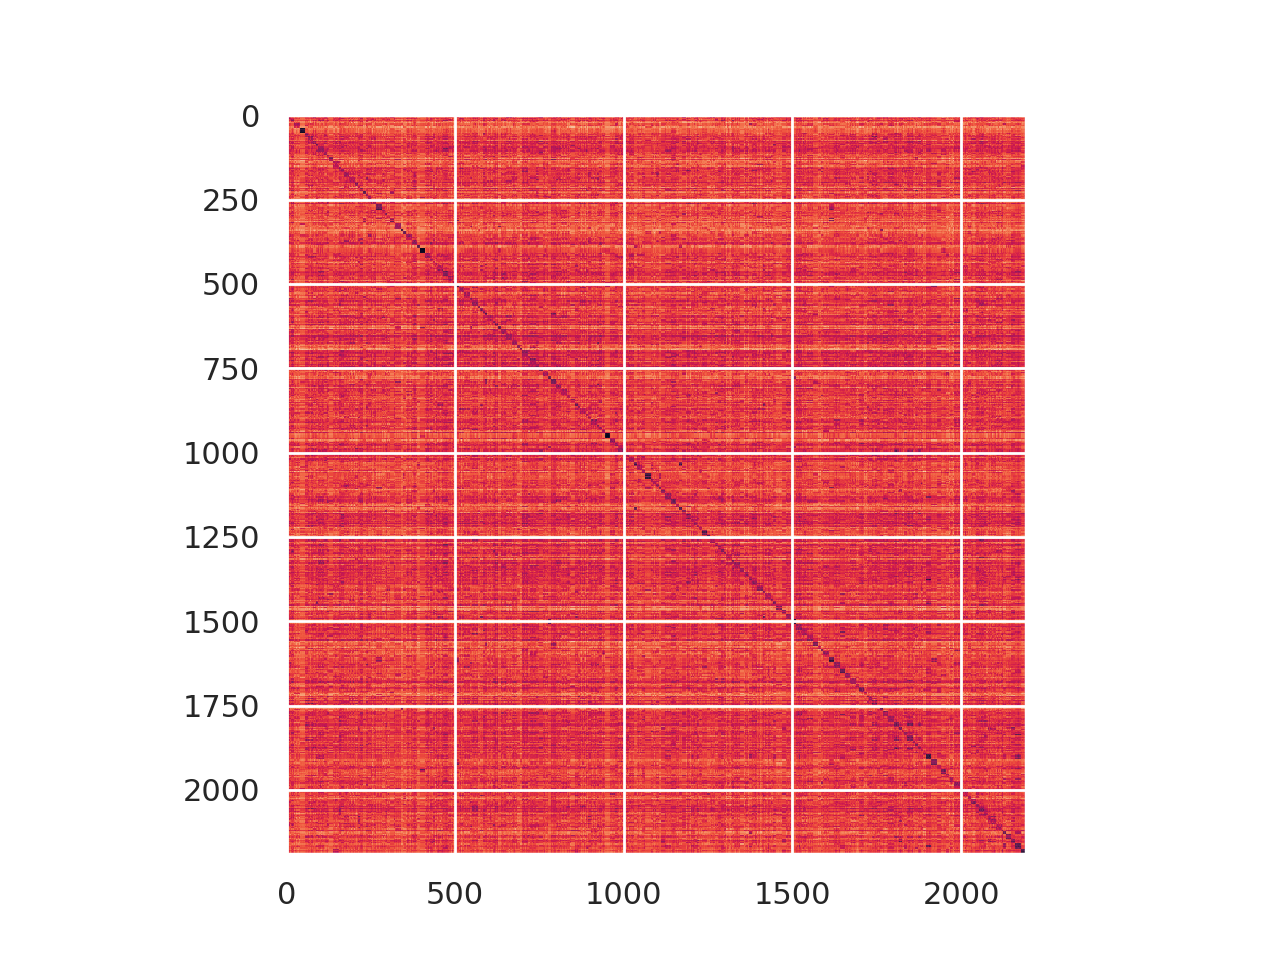

In [119]:
plt.figure()
plt.imshow(D_nn)

## Clustering Based on MOA in the original spaces versus CCA space - CDRP or TAORF

In [11]:
mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True).groupby(['size']).size()

size
1     5
2     6
3     4
4     1
5     2
7     1
8     1
9     2
10    1
dtype: int64

In [12]:
# mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True).groupby(['size']).size()

# pertColName
# mergProf_treatLevel['Metadata_moa']

<IPython.core.display.Javascript object>


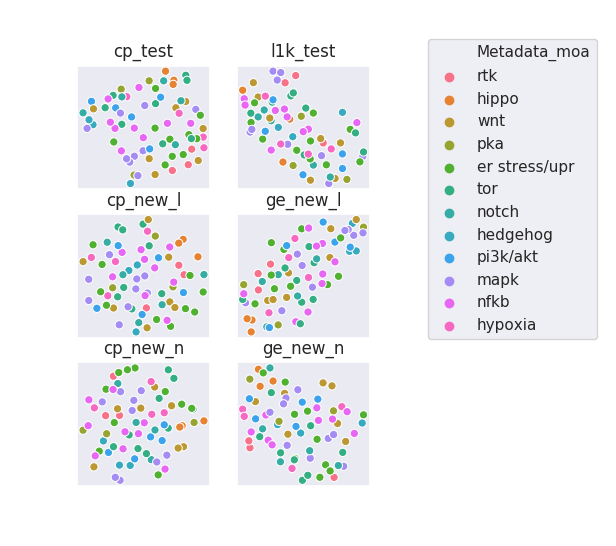

In [14]:
from sklearn.decomposition import PCA
# %matplotlib inline

# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

nSamplesMOA=2
# from MulticoreTSNE import MulticoreTSNE as TSNE
# df_1 = df_1.interpolate()
#############
cp_new_l=pd.DataFrame(MF_v_l)
cp_new_l.insert(0,cp_test.columns[0],cp_test.iloc[:,0])
ge_new_l=pd.DataFrame(GE_v_l)
ge_new_l.insert(0,l1k_test.columns[0],l1k_test.iloc[:,0])

cp_new_n=pd.DataFrame(MF_v_nn)
cp_new_n.insert(0,cp_test.columns[0],cp_test.iloc[:,0])
ge_new_n=pd.DataFrame(GE_v_nn)
ge_new_n.insert(0,l1k_test.columns[0],l1k_test.iloc[:,0])
##########
mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
mergProf_treatLevel=mergProf_treatLevel[~mergProf_treatLevel['Metadata_moa'].isnull()]
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA]['Metadata_moa'].tolist()
# corresPertID=[mergProf_treatLevel[mergProf_treatLevel['Metadata_moa']==i]['Metadata_pert_id'] for i in listOfSelectedMoAs]
# filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)].reset_index(drop=True)
IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)][pertColName].tolist()


umapT=umap.UMAP()
data4umap=[[cp_test,l1k_test],[cp_new_l,ge_new_l],[cp_new_n,ge_new_n]]
fig, axes = plt.subplots(len(data4umap),2, figsize=(10,10))

titleUmaps=[['cp_test','l1k_test'],['cp_new_l','ge_new_l'],['cp_new_n','ge_new_n']]
# writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter')
for r in range(len(data4umap)):
    domXdata=data4umap[r];
    for r2 in range(len(domXdata)):
        domDf=domXdata[r2];
        filteredMOAs=domDf[domDf[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
        data4tsne = filteredMOAs.iloc[:,1:].values;
        Y = umapT.fit_transform(data4tsne)
        tsneResDF=pd.DataFrame(index=range(Y.shape[0]),columns=['one','two',pertColName, 'Metadata_moa']);
        tsneResDF.loc[:,[pertColName]]=filteredMOAs[[pertColName]];
        moaS=[mergProf_treatLevel[mergProf_treatLevel[pertColName]==i]['Metadata_moa'].tolist()[0] for i in filteredMOAs[pertColName].tolist()]
        tsneResDF.loc[:,['Metadata_moa']]=np.expand_dims(moaS, axis=1)
        tsneResDF.loc[:,['one','two']]=Y
#         with pd.ExcelWriter('output.xlsx') as writer:  # doctest: +SKIP
#         tsneResDF.to_excel(writer, sheet_name=titleUmaps[r][r2])
        if r==0 and r2==0:
            g=sns.scatterplot(x="one", y="two", hue="Metadata_moa", data=tsneResDF,ax=axes[r,r2])
        else:
            sns.scatterplot(x="one", y="two", hue="Metadata_moa", data=tsneResDF,legend=False,ax=axes[r,r2])
        axes[r,r2].set_title(titleUmaps[r][r2]);
        axes[r,r2].get_yaxis().set_visible(False)
        axes[r,r2].get_xaxis().set_visible(False)
# axes[r,r2].get_legend().set_visible(False)
g.legend(loc='right', bbox_to_anchor=(4, 0), ncol=1, borderaxespad=0.8)
plt.subplots_adjust(right=.6)
# writer.save()
# plt.draw()
# plt.tight_layout()
# data4tsne = filteredMOAs.loc[:,l1k_features.tolist()];
# # scaler = preprocessing.StandardScaler()
# # dataScaled = scaler.fit_transform(data4tsne)

# # tsne = TSNE(n_jobs=12,perplexity=80,n_iter=1000, n_iter_without_progress=100,random_state=0)
# umapT=umap.UMAP()
# Y = umapT.fit_transform(data4tsne)

# tsneResDF=pd.DataFrame(index=range(Y.shape[0]),columns=['one','two','Metadata_pert_id', 'Metadata_moa', 'Metadata_target']);
# tsneResDF.loc[:,['Metadata_pert_id', 'Metadata_moa', 'Metadata_target']]=filteredMOAs[['Metadata_pert_id', 'Metadata_moa', 'Metadata_target']];
# tsneResDF.loc[:,['one','two']]=Y


# # sns.set(font_scale=0.5);
# # plt.figure()
# sns.scatterplot(x="one", y="two", hue="Metadata_moa", data=tsneResDF,legend=False)
# sns.pairplot(x_vars=["one"], y_vars=["two"], data=tsneResDF,\
#              hue="Metadata_moa",height=8);#,\
# #              plot_kws=dict(s=10,linewidth=0.1,alpha=0.5));



<IPython.core.display.Javascript object>


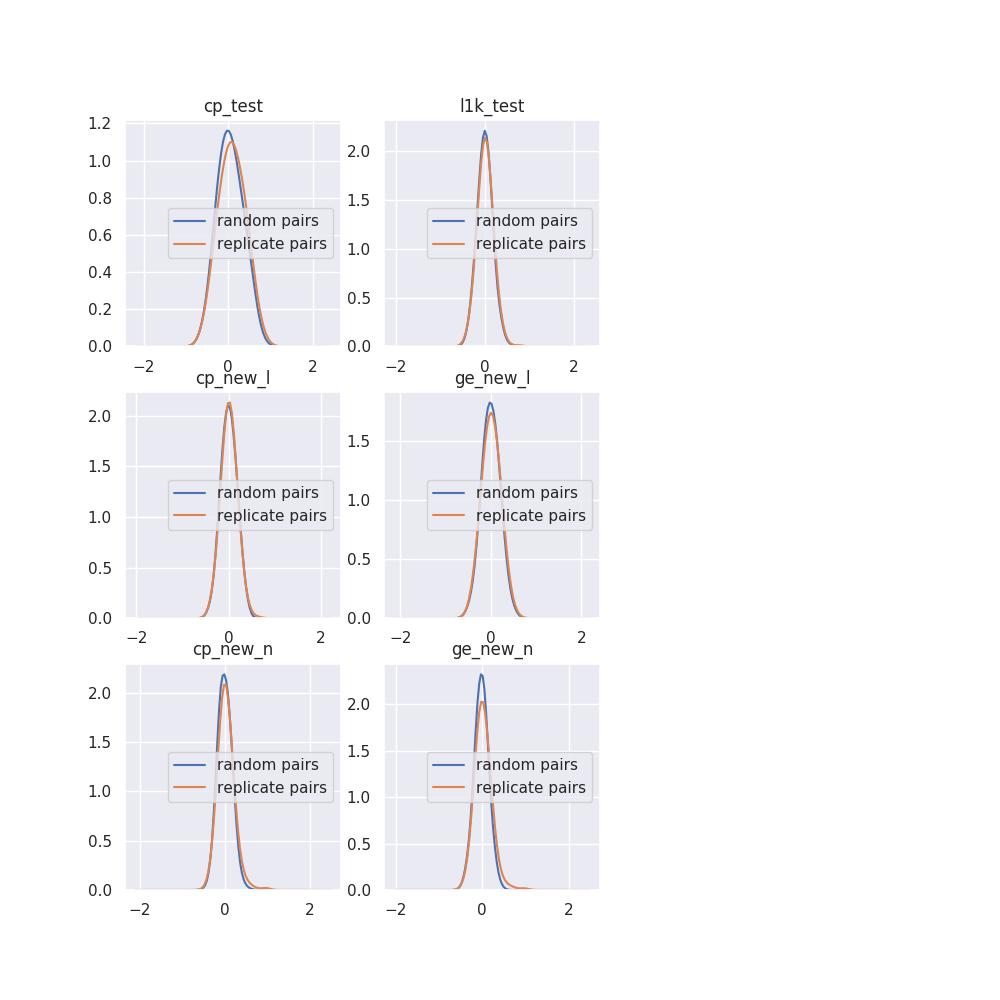

In [8]:
titleUmaps=[['cp_test','l1k_test'],['cp_new_l','ge_new_l'],['cp_new_n','ge_new_n']]
data4umap=[[cp_test,l1k_test],[cp_new_l,ge_new_l],[cp_new_n,ge_new_n]]
fig, axes = plt.subplots(len(data4umap),2, figsize=(10,10))
for r in range(len(data4umap)):
    domXdata=data4umap[r];
    for r2 in range(len(domXdata)):
        domDf=domXdata[r2];
        filteredMOAs=domDf[domDf[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
        moaS=[mergProf_treatLevel[mergProf_treatLevel[pertColName]==i]['Metadata_moa'].tolist()[0] for i in filteredMOAs[pertColName].tolist()]
        filteredMOAs.insert(0, "Metadata_moa", moaS) 
#         filteredMOAs['Metadata_moa']=moaS#np.expand_dims(moaS, axis=1)
        corrX=plotRepCorrs([filteredMOAs],'Metadata_moa')
#         zz
        repCC=corrX[0][1]
        randCC=corrX[0][0]
        sns.kdeplot(randCC, bw=.5, label="random pairs",ax=axes[r,r2])
        sns.kdeplot(repCC, bw=.5, label="replicate pairs",ax=axes[r,r2]);#axes[i].set_xlabel('CC');
        
        axes[r,r2].set_title(titleUmaps[r][r2]);
#         axes[r,r2].get_yaxis().set_visible(False)
#         axes[r,r2].get_xaxis().set_visible(False)
# axes[r,r2].get_legend().set_visible(False)
g.legend(loc='right', bbox_to_anchor=(4, 0), ncol=1, borderaxespad=0.8)
plt.subplots_adjust(right=.6)

In [17]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

In [18]:
# labels_numerical_2

In [23]:
from sklearn.decomposition import PCA
# %matplotlib inline

# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# nSamplesMOA=10 # results in grant for CDRP are for this number of MOAs
nSamplesMOA=4
# from MulticoreTSNE import MulticoreTSNE as TSNE
# df_1 = df_1.interpolate()
#############
cp_new_l=pd.DataFrame(MF_v_l)
cp_new_l.insert(0,cp_test.columns[0],cp_test.iloc[:,0])
ge_new_l=pd.DataFrame(GE_v_l)
ge_new_l.insert(0,l1k_test.columns[0],l1k_test.iloc[:,0])

cp_new_n=pd.DataFrame(MF_v_nn)
cp_new_n.insert(0,cp_test.columns[0],cp_test.iloc[:,0])
ge_new_n=pd.DataFrame(GE_v_nn)
ge_new_n.insert(0,l1k_test.columns[0],l1k_test.iloc[:,0])
##########
mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
mergProf_treatLevel=mergProf_treatLevel[~mergProf_treatLevel['Metadata_moa'].isnull()]
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA]['Metadata_moa'].tolist()
# corresPertID=[mergProf_treatLevel[mergProf_treatLevel['Metadata_moa']==i]['Metadata_pert_id'] for i in listOfSelectedMoAs]
# filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)].reset_index(drop=True)
IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)][pertColName].tolist()


umapT=umap.UMAP()
# data4umap=[[cp_test,l1k_test],[cp_new_l,ge_new_l],[cp_new_n,ge_new_n]]
data4umap=[[cp_test,l1k_test],[cp_new_n,ge_new_n]]
# fig, axes = plt.subplots(len(data4umap),2, figsize=(10,10))

# titleUmaps=[['cp_test','l1k_test'],['cp_new_l','ge_new_l'],['cp_new_n','ge_new_n']]
titleUmaps=[['cp_test','l1k_test'],['cp_new_n','ge_new_n']]
# writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter')
accAll=[]
for r in range(len(data4umap)):
    domXdata=data4umap[r];
    acc4eachMethod=[]
    for r2 in range(len(domXdata)):
        print(r,r2)
        domDf=domXdata[r2];
        filteredMOAs=domDf[domDf[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
        moaS=[mergProf_treatLevel[mergProf_treatLevel[pertColName]==i]['Metadata_moa'].tolist()[0] for i in filteredMOAs[pertColName].tolist()]
        filteredMOAs.insert(0, "Metadata_moa", moaS) 
        data = filteredMOAs.iloc[:,2:].values;
        labels=filteredMOAs.Metadata_moa.tolist()
        le_2 = preprocessing.LabelEncoder()
        labels_categorical_2=filteredMOAs.Metadata_moa.unique().tolist();
        le_2.fit(labels_categorical_2)
        labels_numerical_2=le_2.transform(labels)

        overSampleMinorityFirstClassTo=20
        ratios = {le_2.transform([l])[0]: overSampleMinorityFirstClassTo for l in labels_categorical_2 \
                  if np.sum(labels_numerical_2==le_2.transform([l]))<overSampleMinorityFirstClassTo}
        sm2=RandomOverSampler(ratio=ratios)
        model2 = RandomForestClassifier(n_estimators=1000)
#         model2 = LogisticRegression(multi_class='ovr',solver='liblinear')
        acc3,predLabels3=balanceLeaveOneOutCV_2(model2,data,labels_numerical_2,sm2)
        acc4eachMethod.append(acc3);
    accAll.append(acc4eachMethod);

0 0


/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sampl

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sampl

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

0 1


/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sampl

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sampl

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

1 0


/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sampl

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sampl

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

1 1


/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sampl

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 9)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sampl

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 6 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 0 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 5 will be larger than the number of samples in the majority class (class #0 -> 10)
  n_samples_majority))
/home/marziehhaghighi/.local/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (20) in class 3 will be larger than the number of sa

In [55]:
# TAORF
accAll

[[0.556390977443609, 0.5939849624060151],
 [0.5714285714285714, 0.5413533834586466]]

In [24]:
# TAORF
accAll

[[0.5714285714285714, 0.6015037593984962],
 [0.556390977443609, 0.5789473684210527]]

In [43]:
accAll

[[0.1252847380410023, 0.14350797266514806],
 [0.1480637813211845, 0.1366742596810934]]

In [41]:
accAll

[[0.11161731207289294, 0.14123006833712984],
 [0.13895216400911162, 0.14123006833712984]]

In [31]:
accAll

[[0.13439635535307518, 0.14350797266514806],
 [0.11617312072892938, 0.10022779043280182],
 [0.1275626423690205, 0.15034168564920272]]

In [36]:
accAll

[[0.11389521640091116, 0.13895216400911162],
 [0.12300683371298406, 0.13211845102505695]]

In [33]:
accAll

[[0.12300683371298406, 0.12300683371298406],
 [0.1571753986332574, 0.12300683371298406]]

In [39]:
accAll

[[0.14123006833712984, 0.12300683371298406],
 [0.1571753986332574, 0.14350797266514806]]

In [13]:
# model2 = LogisticRegression(multi_class='ovr',solver='liblinear')
# [[0.10416666666666667, 0.11378205128205128],
#  [0.0673076923076923, 0.06891025641025642],
#  [0.08493589743589744, 0.08814102564102565]]

[[0.10416666666666667, 0.11378205128205128],
 [0.0673076923076923, 0.06891025641025642],
 [0.08493589743589744, 0.08814102564102565]]

In [39]:
# mergProf_treatLevel.columns[mergProf_treatLevel.columns.str.contains('Metadata')]
# len([mergProf_treatLevel[mergProf_treatLevel['Metadata_pert_id']==i]['Metadata_moa'].tolist()[0] for i in filteredMOAs['Metadata_pert_id'].tolist()])
# filteredMOAs.groupby(['Metadata_moa']).size()
# len(corrX[0][0])
# corrX[0][1]
# ratios
# len(labels_categorical_2)
# labels_categorical_2
r,r2

(0, 0)

In [ ]:
Tissue cells and segment cells first and then assign gene expression 
multi cut for segmentation


In [79]:
# domDf['Metadata_pert_id'].shape
# listOfSelectedMoAs
# filteredMOAs.columns
# moaS
# filteredMOAs['Metadata_moa'].shape
# def plotRepCorrs(allData,pertName):
#     corrAll=[]
#     for d in range(len(allData)):
#         df=allData[d];
#         uniqPert=df[pertName].unique().tolist()
#         repC=[]
#         randC=[]
#         for u in uniqPert:
#             df1=df[df[pertName]==u].drop_duplicates().reset_index(drop=True)
#             df2=df[df[pertName]!=u].drop_duplicates().reset_index(drop=True)
#             repCorr=np.sort(np.unique(df1.loc[:,df1.columns[df1.columns.str.contains("Metadata")!=True]].T.corr().values))[:-1].tolist()
#             repC=repC+repCorr
#             randAllels=df2[pertName].drop_duplicates().sample(df1.shape[0],replace=True).tolist()
#             df3=pd.concat([df2[df2[pertName]==i].reset_index(drop=True).iloc[0:1,:] for i in randAllels],ignore_index=True)
#             randCorr=df1.corrwith(df3, axis = 1,method='pearson').values.tolist()
#             randC=randC+randCorr

#         corrAll.append([randC,repC]);
#     return corrAll
def plotRepCorrs(allData,pertName):
#     allData=[cp_test,l1k_test]
    corrAll=[]
    # pertName=pertColName
    for d in range(len(allData)):
        df=allData[d];
        uniqPert=df[pertName].unique().tolist()
        repC=[]
        randC=[]
        for u in uniqPert:
            df1=df[df[pertName]==u].drop_duplicates().reset_index(drop=True)
            df2=df[df[pertName]!=u].drop_duplicates().reset_index(drop=True)
            repCorr=np.sort(np.unique(df1.iloc[:,1:].T.corr().values))[:-1].tolist()
            repC=repC+repCorr
            randAllels=df2[pertName].drop_duplicates().sample(df1.shape[0],replace=True).tolist()
            df3=pd.concat([df2[df2[pertName]==i].reset_index(drop=True).iloc[0:1,:] for i in randAllels],ignore_index=True)
            randCorr=df1.corrwith(df3, axis = 1,method='pearson').values.tolist()
            randC=randC+randCorr

        corrAll.append([randC,repC]);
    return corrAll

In [63]:
# mergProf_treatLevel[['Metadata_pert_id', 'Metadata_moa', 'Metadata_target']]
# mergProf_treatLevel
# np.array(moaS).shape
# df.loc[:,df.columns[df.columns.str.contains("Metadata")!=True]]
# repCorr
# randAllels
# df3
randCorr

[0.06678174353107436, -0.04051915181943964, 0.08485536879970716]

In [56]:
# def plotRepCorrs(allData,pertName):
corrAll=[]
for d in range(len(allData)):
    df=allData[d];
    uniqPert=df[pertName].unique().tolist()
    repC=[]
    randC=[]
    for u in uniqPert:
        df1=df[df[pertName]==u].drop_duplicates().reset_index(drop=True)
        df2=df[df[pertName]!=u].drop_duplicates().reset_index(drop=True)
        repCorr=np.sort(np.unique(df1.iloc[:,1:].T.corr().values))[:-1].tolist()
        repC=repC+repCorr
        randAllels=df2[pertName].drop_duplicates().sample(df1.shape[0],replace=True).tolist()
        df3=pd.concat([df2[df2[pertName]==i].reset_index(drop=True).iloc[0:1,:] for i in randAllels],ignore_index=True)
        randCorr=df1.corrwith(df3, axis = 1,method='pearson').values.tolist()
        randC=randC+randCorr

    corrAll.append([randC,repC]);
#     return corrAll

In [58]:
# df.columns[df.columns.str.contains("Metadata")==True]
# [df2[df2[pertName]==i].reset_index(drop=True).iloc[0:1,:] for i in randAllels]
randAllels

['notch', 'circadian rhythm', 'hypoxia']

In [59]:
# len(mergProf_treatLevel['Metadata_moa'].unique())
df2[df2[pertName]=='notch'].reset_index(drop=True).iloc[0:1,:]

,Metadata_moa,Metadata_gene_name,0,1,2,3,4,5,6,7,...,30,31,32,33,34,35,36,37,38,39
0,notch,DLL1,1.630432,-0.305335,-1.483914,-2.066162,-0.628577,0.495531,-0.431785,2.107099,...,-0.536494,2.158031,-0.39274,-0.228779,-0.284671,-1.173328,-0.556437,-0.883424,-0.111573,0.944995


In [60]:
df3

,Metadata_moa,Metadata_gene_name,0,1,2,3,4,5,6,7,...,30,31,32,33,34,35,36,37,38,39
0,notch,DLL1,1.630432,-0.305335,-1.483914,-2.066162,-0.628577,0.495531,-0.431785,2.107099,...,-0.536494,2.158031,-0.392740,-0.228779,-0.284671,-1.173328,-0.556437,-0.883424,-0.111573,0.944995
1,circadian rhythm,ARNTL,1.077713,-1.110417,0.775960,-3.035867,0.906598,-0.652340,0.603827,0.080656,...,0.006744,0.316256,-0.678280,0.344267,0.322592,0.660575,0.162437,0.114167,-1.598984,-1.017883
2,hypoxia,EGLN1,1.529589,1.153394,0.132882,0.845797,-1.081332,1.659669,1.908782,-0.508086,...,-0.155362,0.568268,-0.494515,0.502812,0.363825,-0.309923,-1.351451,0.024768,0.647626,1.101707


In [72]:
# mergProf_treatLevel.groupby(['Metadata_moa']).size().mean()
GE_v_l.shape

(320, 40)

## Experiment : replicate correlation in the latent space
    - We use all the data samples and map them to CCA sapce and check how replicate correlations look like

#### Replicate correlation in the linear CCA latent space 

<IPython.core.display.Javascript object>


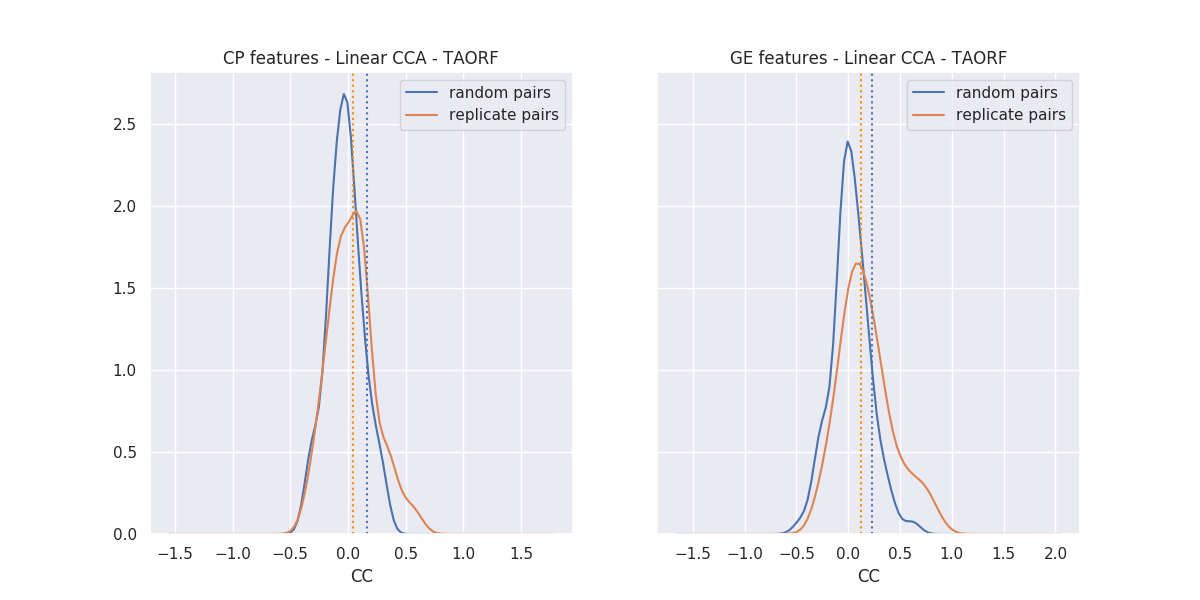

In [44]:
outdim_size=40;
MF_v_l, GE_v_l, _= cca_analysis2(l1k_train, cp_train, l1k_test, cp_test, outdim_size);

cp_new=pd.DataFrame(MF_v_l)
cp_new.insert(0,cp.columns[0],cp.iloc[:,0])
ge_new=pd.DataFrame(GE_v_l)
ge_new.insert(0,l1k.columns[0],l1k.iloc[:,0])
corrAll_linCCA=plotRepCorrs([cp_new, ge_new],pertColName)
repC_all=corrAll_linCCA.copy()
title=['CP features - Linear CCA - '+dataset,'GE features - Linear CCA - '+dataset]
fig, axes = plt.subplots(1,len(repC_all),sharey='row', figsize=(12,6))
for i in range(len(repC_all)):
# sns.kdeplot(x)
    repCC=repC_all[i][1]
    randCC=repC_all[i][0]
    sns.kdeplot(randCC, bw=.4, label="random pairs",ax=axes[i])
    sns.kdeplot(repCC, bw=.4, label="replicate pairs",ax=axes[i]);axes[i].set_xlabel('CC');
    perc5=np.percentile(repCC, 50);axes[i].axvline(x=perc5,linestyle=':',color='darkorange');
    perc95=np.percentile(randCC, 90);axes[i].axvline(x=perc95,linestyle=':');
    axes[i].legend();axes[i].set_title(title[i]);

In [26]:
# repC_all[0][1]
# MF_v_nn
# repCC

#### Replicate correlation in the Deep CCA latent space

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/marziehhaghighi/rosetta-cca/ec0dce2eaf444259aab6e8f084e1ae87
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [300]         : (-35.75482177734375, -5.0891923904418945)
COMET INFO:     epoch_duration [300]     : (0.08293401822447777, 1.190794313326478)
COMET INFO:     loss [300]               : (-35.68797619362188, -6.373634310272651)
COMET INFO:     step                     : 1200
COMET INFO:     sys.gpu.0.free_memory    : (12438142976.0, 12438142976.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (12796690432.0, 12796690432.0)
COMET INFO:     sys.gpu.0.used_memory    : (358547456.0, 358547456.0)
COMET INFO:     sys.gpu.1.free_memory    : (12775915520.0, 12775915520.0)
COMET INFO:     sys.gpu.1.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.1.total_memory   : (12788498

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_49_input (InputLayer)     (None, 1677)         0                                            
__________________________________________________________________________________________________
dense_53_input (InputLayer)     (None, 978)          0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 64)           107392      dense_49_input[0][0]             
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 64)           62656       dense_53_input[0][0]             
__________________________________________________________________________________________________
dense_50 (

Linear CCA started!
4
Linear CCA ended!


<IPython.core.display.Javascript object>


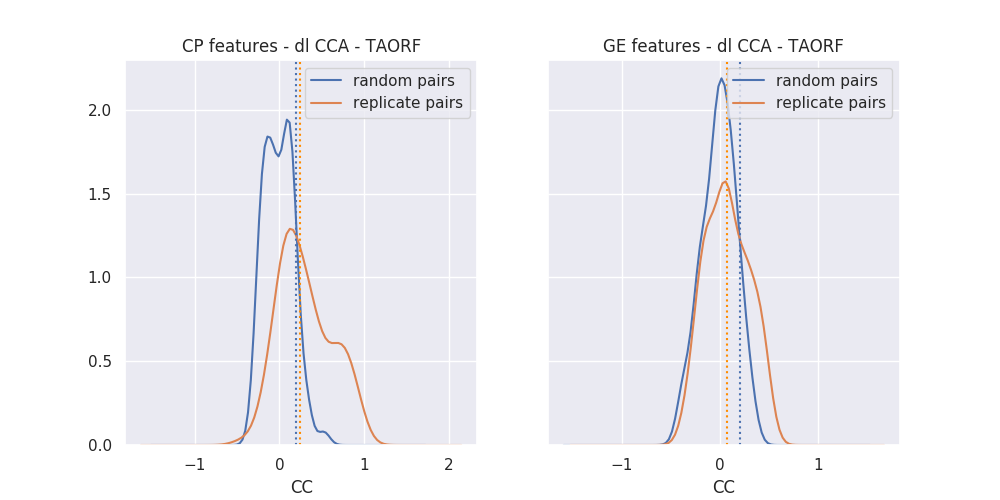

In [46]:
outdim_size=40;
MF_v_nn, GE_v_nn, _= deep_cca_analysis(l1k_train, cp_train, l1k_test, cp_test, outdim_size,valEnabled=1,n_epoch=30);

cp_new=pd.DataFrame(MF_v_nn)
cp_new.insert(0,cp.columns[0],cp.iloc[:,0])
ge_new=pd.DataFrame(GE_v_nn)
ge_new.insert(0,l1k.columns[0],l1k.iloc[:,0])
corrAll_deepCCA=plotRepCorrs([cp_new, ge_new],pertColName)
repC_all=corrAll_deepCCA.copy()
title=['CP features - dl CCA - '+dataset,'GE features - dl CCA - '+dataset]
fig, axes = plt.subplots(1,len(repC_all),sharey='row', figsize=(10,5))
for i in range(len(repC_all)):
# sns.kdeplot(x)
    repCC=repC_all[i][1]
    randCC=repC_all[i][0]
    sns.kdeplot(randCC, bw=.4, label="random pairs",ax=axes[i])
    sns.kdeplot(repCC, bw=.4, label="replicate pairs",ax=axes[i]);axes[i].set_xlabel('CC');
    perc5=np.percentile(repCC, 50);axes[i].axvline(x=perc5,linestyle=':',color='darkorange');
    perc95=np.percentile(randCC, 90);axes[i].axvline(x=perc95,linestyle=':');
    axes[i].legend();axes[i].set_title(title[i]);

In [207]:
# GE_v.shape[0]
# print(l1k.shape,MF_v_lin.shape,cp.shape,MF_v_lin.shape,D.shape)

In [120]:
l1k.columns[l1k.sum().isnull()]

Index([], dtype='object')

In [8]:
ls ../DeepCCAmaster

DeepCCA.py*  README.md*    linear_cca.py*  objectives.py*
LICENSE*     __pycache__/  models.py*      utils.py*


In [9]:
print(MF.shape, GE.shape)

(688, 255) (688, 978)


In [4]:
from sklearn import preprocessing
l1kAl=l1k.Allele.tolist()
cpAl=cp.Allele.tolist()
le = preprocessing.LabelEncoder()
le.fit(list(set(l1kAl)))
l_labels=le.transform(l1kAl)
le2 = preprocessing.LabelEncoder()
le2.fit(list(set(cpAl)))
c_labels=le2.transform(cpAl)

In [27]:
importlib.reload(models)
importlib.reload(DeepCCA)
importlib.reload(objectives)

<module 'DeepCCAmaster.objectives' from '../DeepCCAmaster/objectives.py'>

In [28]:
new_data = DeepCCA.test_model(model, data1, data2, outdim_size, apply_linear_cca)

Linear CCA started!
20 20 20 20
4
Linear CCA ended!


In [37]:
test_data.shape

(4, 20)

In [43]:
importlib.reload(models)
importlib.reload(DeepCCA)
importlib.reload(objectives)
# if __name__ == '__main__':
    ############
    # Parameters Section

# the path to save the final learned features
save_to = './new_features.gz'

# the size of the new space learned by the model (number of the new features)
outdim_size = 20

# size of the input for view 1 and view 2
# input_shape1 = 784
# input_shape2 = 784
input_shape1 = 255
input_shape2 = 978

# number of layers with nodes in each one
layer_sizes1 = [1024, 1024, 1024, outdim_size]
layer_sizes2 = [1024, 1024, 1024, outdim_size]

# the parameters for training the network
learning_rate = 1e-3
epoch_num = 100
# batch_size = 800
batch_size = 684

# the regularization parameter of the network
# seems necessary to avoid the gradient exploding especially when non-saturating activations are used
reg_par = 1e-5

# specifies if all the singular values should get used to calculate the correlation or just the top outdim_size ones
# if one option does not work for a network or dataset, try the other one
use_all_singular_values = False

# if a linear CCA should get applied on the learned features extracted from the networks
# it does not affect the performance on noisy MNIST significantly
apply_linear_cca = True

# end of parameters section
############

# Each view is stored in a gzip file separately. They will get downloaded the first time the code gets executed.
# Datasets get stored under the datasets folder of user's Keras folder
# normally under [Home Folder]/.keras/datasets/
# data1 = load_data('noisymnist_view1.gz', 'https://www2.cs.uic.edu/~vnoroozi/noisy-mnist/noisymnist_view1.gz')
# data2 = load_data('noisymnist_view2.gz', 'https://www2.cs.uic.edu/~vnoroozi/noisy-mnist/noisymnist_view2.gz')
# data1=np.copy(MF)
# data2=np.copy(GE)
lx_tr=al1k_train.iloc[:,1:].values;
ly_tr=le.transform(al1k_train.Allele.tolist())
lx_te=al1k_test.iloc[:,1:].values;
ly_te=le.transform(al1k_test.Allele.tolist())

cx_tr=acp_train.iloc[:,1:].values;
cy_tr=le2.transform(acp_train.Allele.tolist())
cx_te=acp_test.iloc[:,1:].values;
cy_te=le2.transform(acp_test.Allele.tolist())

data2=((lx_tr,ly_tr),(lx_te,ly_te),(lx_te,ly_te))
data1=((cx_tr,cy_tr),(cx_te,cy_te),(cx_te,cy_te))

# Building, training, and producing the new features by DCCA

model = models.create_model(layer_sizes1, layer_sizes2, input_shape1, input_shape2,
                        learning_rate, reg_par, outdim_size, use_all_singular_values)
model.summary()
model = DeepCCA.train_model(model, data1, data2, epoch_num, batch_size)
new_data = DeepCCA.test_model(model, data1, data2, outdim_size, apply_linear_cca)

test_data, _, test_label = new_data[2]
cx_cca_tr, lx_cca_tr, label_tr = new_data[0]
# # Training and testing of SVM with linear kernel on the view 1 with new features
# [test_acc, valid_acc] = models.svm_classify(new_data, C=0.01)
# print("Accuracy on view 1 (validation data) is:", valid_acc * 100.0)
# print("Accuracy on view 1 (test data) is:", test_acc*100.0)

# # Saving new features in a gzip pickled file specified by save_to
# print('saving new features ...')
# f1 = gzip.open(save_to, 'wb')
# thepickle.dump(new_data, f1)
# f1.close()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_33_input (InputLayer)     (None, 255)          0                                            
__________________________________________________________________________________________________
dense_37_input (InputLayer)     (None, 978)          0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 1024)         262144      dense_33_input[0][0]             
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 1024)         1002496     dense_37_input[0][0]             
__________________________________________________________________________________________________
dense_34 (


Epoch 00036: saving model to temp_weights.h5
Epoch 37/100
684/684 [==============================] - 0s 121us/step - loss: -15.8412 - val_loss: -3.0693

Epoch 00037: saving model to temp_weights.h5
Epoch 38/100
684/684 [==============================] - 0s 120us/step - loss: -15.9426 - val_loss: -3.0816

Epoch 00038: saving model to temp_weights.h5
Epoch 39/100
684/684 [==============================] - 0s 119us/step - loss: -16.0066 - val_loss: -3.0879

Epoch 00039: saving model to temp_weights.h5
Epoch 40/100
684/684 [==============================] - 0s 124us/step - loss: -16.1275 - val_loss: -3.0951

Epoch 00040: saving model to temp_weights.h5
Epoch 41/100
684/684 [==============================] - 0s 121us/step - loss: -16.1681 - val_loss: -3.1346

Epoch 00041: saving model to temp_weights.h5
Epoch 42/100
684/684 [==============================] - 0s 116us/step - loss: -16.3047 - val_loss: -3.1261

Epoch 00042: saving model to temp_weights.h5
Epoch 43/100
684/684 [==============


Epoch 00090: saving model to temp_weights.h5
Epoch 91/100
684/684 [==============================] - 0s 118us/step - loss: -18.7167 - val_loss: -4.0909

Epoch 00091: saving model to temp_weights.h5
Epoch 92/100
684/684 [==============================] - 0s 124us/step - loss: -18.7340 - val_loss: -4.3719

Epoch 00092: saving model to temp_weights.h5
Epoch 93/100
684/684 [==============================] - 0s 117us/step - loss: -18.7409 - val_loss: -4.2582

Epoch 00093: saving model to temp_weights.h5
Epoch 94/100
684/684 [==============================] - 0s 118us/step - loss: -18.7717 - val_loss: -4.1746

Epoch 00094: saving model to temp_weights.h5
Epoch 95/100
684/684 [==============================] - 0s 118us/step - loss: -18.7750 - val_loss: -4.2951

Epoch 00095: saving model to temp_weights.h5
Epoch 96/100
684/684 [==============================] - 0s 115us/step - loss: -18.8257 - val_loss: -4.3164

Epoch 00096: saving model to temp_weights.h5
Epoch 97/100
684/684 [==============

In [10]:
# from keras.utils.data_utils import get_file
# def load_data(data_file, url):
#     """loads the data from the gzip pickled files, and converts to numpy arrays"""
#     print('loading data ...')
#     path = get_file(data_file, origin=url)
#     f = gzip.open(path, 'rb')
#     train_set, valid_set, test_set = load_pickle(f)
#     f.close()

#     train_set_x, train_set_y = make_numpy_array(train_set)
#     valid_set_x, valid_set_y = make_numpy_array(valid_set)
#     test_set_x, test_set_y = make_numpy_array(test_set)

#     return [(train_set_x, train_set_y), (valid_set_x, valid_set_y), (test_set_x, test_set_y)]


# data1 = load_data('noisymnist_view1.gz', 'https://www2.cs.uic.edu/~vnoroozi/noisy-mnist/noisymnist_view1.gz')
# data2 = load_data('noisymnist_view2.gz', 'https://www2.cs.uic.edu/~vnoroozi/noisy-mnist/noisymnist_view2.gz')

In [21]:
# leave one sample out function
def balanceLeaveOneOutCV_2(model,data,labels,sm1):
    import time
    from sklearn.model_selection import LeaveOneOut
    loo = LeaveOneOut()
    acc=[]
    predLabels=np.zeros((labels.shape[0]), dtype=int)
    i=0;
    start_time = time.time()
    for train_index, test_index in loo.split(data):
        
#         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
#         sm = SMOTE()
        if sm1!=[]:
            X_sm1, y_sm1 = sm1.fit_sample(X_train, y_train)
        else:
            X_sm1, y_sm1 = np.copy(X_train),np.copy(y_train)
        sm=RandomUnderSampler()
#         print(i,X_train.shape,y_train.shape)
        data_res_train, labels_res_train = sm.fit_sample(X_sm1, y_sm1)
        model.fit(data_res_train, labels_res_train)                  
        y_model = model.predict(X_test);
        acc.append(accuracy_score(y_test, y_model));
        predLabels[i]=y_model;
        elapsed_time = time.time() - start_time
        
        i+=1
#     print(elapsed_time)    
    return np.mean(acc),predLabels